### TSMC2330 Stock Price Up/Down Estimation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance


### 繪製模型訓練準確率直條圖 function

In [15]:
def performanceChart(report:dict):
    import matplotlib.pyplot as plt
    import numpy as np

    # 1. 先設定 matplotlib 的中文字型（以 Windows 微軟正黑體為例）
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或 'SimHei'，視你系統字型而定
    plt.rcParams['axes.unicode_minus'] = False  # 讓負號正常顯示

    # 2. 在設定 seaborn 風格時，再指定字型（必須在 import seaborn 後執行）
    sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei', 'Arial']})

    labels = ['precision', 'recall', 'f1-score']
    class0 = [round(report['0']['precision'],2), round(report['0']['recall'],2), round(report['0']['f1-score'],2)]
    class1 = [round(report['1']['precision'],2), round(report['1']['recall'],2), round(report['1']['f1-score'],2)]
    support = [round(report['0']['support'],2), round(report['1']['support'],2)]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8,4))

    # 第一張：分數指標
    import matplotlib.pyplot as plt
    import numpy as np

    labels = ['precision', 'recall', 'f1-score']
    class0 = [round(report['0']['precision'],2), round(report['0']['recall'],2), round(report['0']['f1-score'],2)]
    class1 = [round(report['1']['precision'],2), round(report['1']['recall'],2), round(report['1']['f1-score'],2)]
    support = [round(report['0']['support'],2), round(report['1']['support'],2)]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, class0, width, label='跌(0)', color='#1985DD')
    bars2 = ax.bar(x + width/2, class1, width, label='漲(1)', color='#FF8C00')
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')


# 調整圖例位置，往左移至第一個長條上方附近
    ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.0), labelspacing=0.2)

    ax.set_ylabel('分數')
    ax.set_title('precision/recall/f1-score')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    plt.show()


    # 第二張：support
    plt.subplot(1,2,2)
    plt.bar(['跌 (0)', '漲 (1)'], support, color=['#1985DD', '#EE9536'])
    plt.ylabel('數量')
    plt.title('support')
    for i, v in enumerate(support):
        plt.text(i, v+3, str(v), ha='center')

    plt.tight_layout()
    plt.show()


### 由 Yahoo Finance 下載台股 2330.TW 資料

In [16]:
import yfinance as yf
# 下載台積電股價資料
data = yf.download(
    ["2330.TW"],
    start="2020-01-01",
    end="2025-06-03",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    prepost=False,
    threads=True,
)

# 將資料寫入 CSV 檔案
data.to_csv("tsmc2330.csv", encoding="utf-8-sig")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['2330.TW']: CertificateVerifyError('Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [17]:
# header=1 表示跳過第一列（原本的header），直接把第二列當作欄位名稱
df = pd.read_csv('tsmc2330.csv', header=1)

# 刪除第一列（原資料的第一列，現在是索引0）
df = df.drop(0).reset_index(drop=True)
df.rename(columns={'A1': 'Date'}, inplace=True)

#print("原本欄位名稱：", df.columns.tolist())

# 修改第一欄的欄位名稱
cols = df.columns.tolist()
cols[0] = 'Date'  # 改成你想要的新名稱
df.columns = cols

# 確認修改後欄位名稱
#print("修改後欄位名稱：", df.columns.tolist())

# 儲存結果
df.to_csv('tsmc2330.csv', index=False)

#### 特徵工程：加入技術指標 (MA5, MA10, MA20, RSI, BB band_upper, BB band_lower.), 
#### 將Return欄 漲、跌欄位標準化改為 0(跌、平盤), 1(漲)，並放在最後一欄 Target 做為目標值

In [18]:
import pandas as pd
import numpy as np

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(price, slow=26, fast=12, signal=9):
    ema_fast = price.ewm(span=fast).mean()
    ema_slow = price.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def compute_bollinger_bands(price, window=20, num_std=2):
    ma = price.rolling(window=window).mean()
    std = price.rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return upper_band, lower_band


# 1. 讀取資料
df = pd.read_csv("tsmc2330.csv")

# 2. 新增技術指標
df["Return"] = df["Close"].pct_change()*100
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA20"] = df["Close"].rolling(window=20).mean()
df["Price_Change"] = df["Close"] - df["Open"]

# RSI
df["RSI"] = compute_rsi(df["Close"])

# MACD & Signal Line
df["MACD"], df["MACD_Signal"] = compute_macd(df["Close"])

# Bollinger Bands
df["BB_Upper"], df["BB_Lower"] = compute_bollinger_bands(df["Close"])

# 3. 處理漲跌目標欄位
#df["Increase"] = df["Increase"].str.replace("%", "").astype(float)
#標準化 "return" 成為Target 欄位: -1 (跌) 0 (漲), 1 (漲)
df["Target"] = df['Return'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0))

# 移除缺失值
df.dropna(inplace=True)
#df.head()


df.to_csv('tsmc2330-1.csv', index = False)

### 讀取資料

In [19]:
# 🔹 讀取資料
df = pd.read_csv("tsmc2330-1.csv")
#df["Date"] = pd.to_datetime(df["Date"])
#df = df.sort_values("Date")
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target


In [20]:
features = df.drop(columns=["Date", "Target"])  # 特徵值不包含 日期 及 Target 欄位
X = features
y = df["Target"]  #設定目標值在 Target 欄位

In [21]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 上面的變數 features 存放各個特徵變數的資料。
除了 "Date","Target" 2 個欄位外，其餘欄位做 RobustScalor 標準化並寫入 tsmc2330-2_Robust.csv，"Date","Target" 2欄原始資料請一併寫入至原來的欄位位置。

In [22]:
from sklearn.preprocessing import RobustScaler

# 需要標準化的欄位
feature_cols = [col for col in df.columns if col not in ["Date", "Target"]]

# RobustScaler 標準化
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# 寫入 CSV
df_scaled.to_csv("tsmc2330-2_Robust.csv", index=False)

ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by RobustScaler.

使用 Prof. J.W.Tukey 在1977年於Exploratory data analysis 所發表的方式計算 tsmc2330-2_Robust.csv 各欄的盒鬚圖及長條圖的常態分佈圖、Q-Q plot. ("Date", "Target" 2欄不用畫圖)

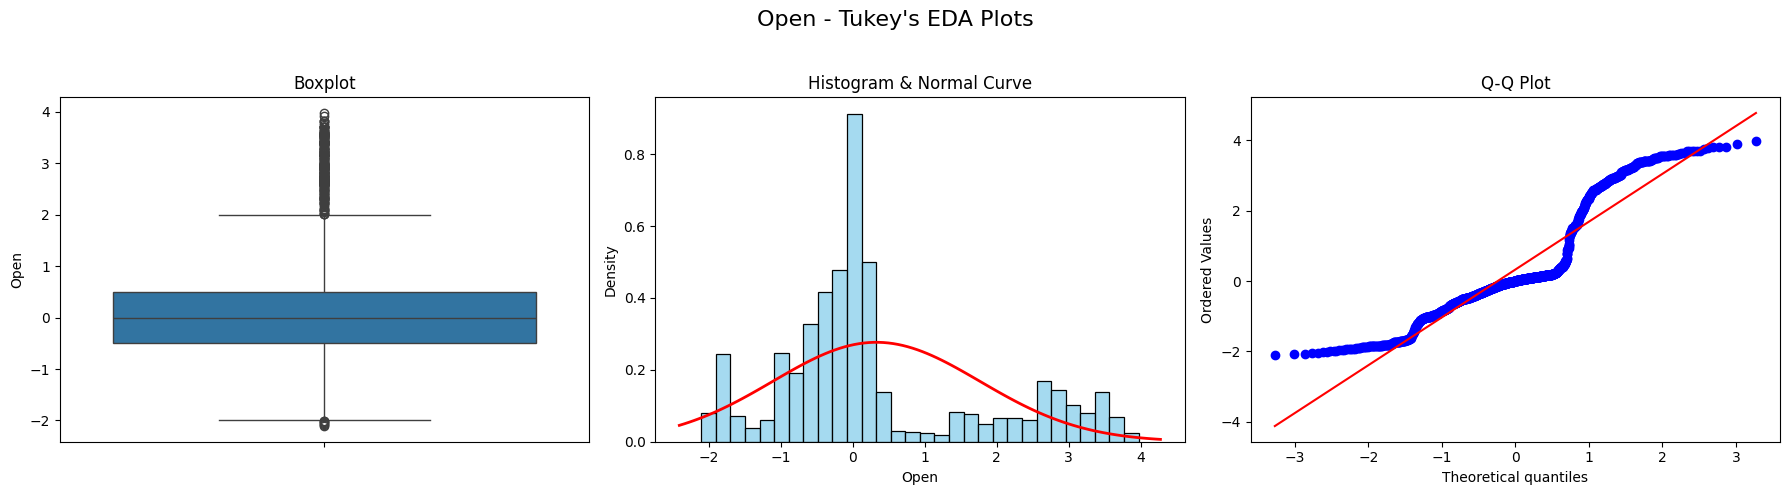

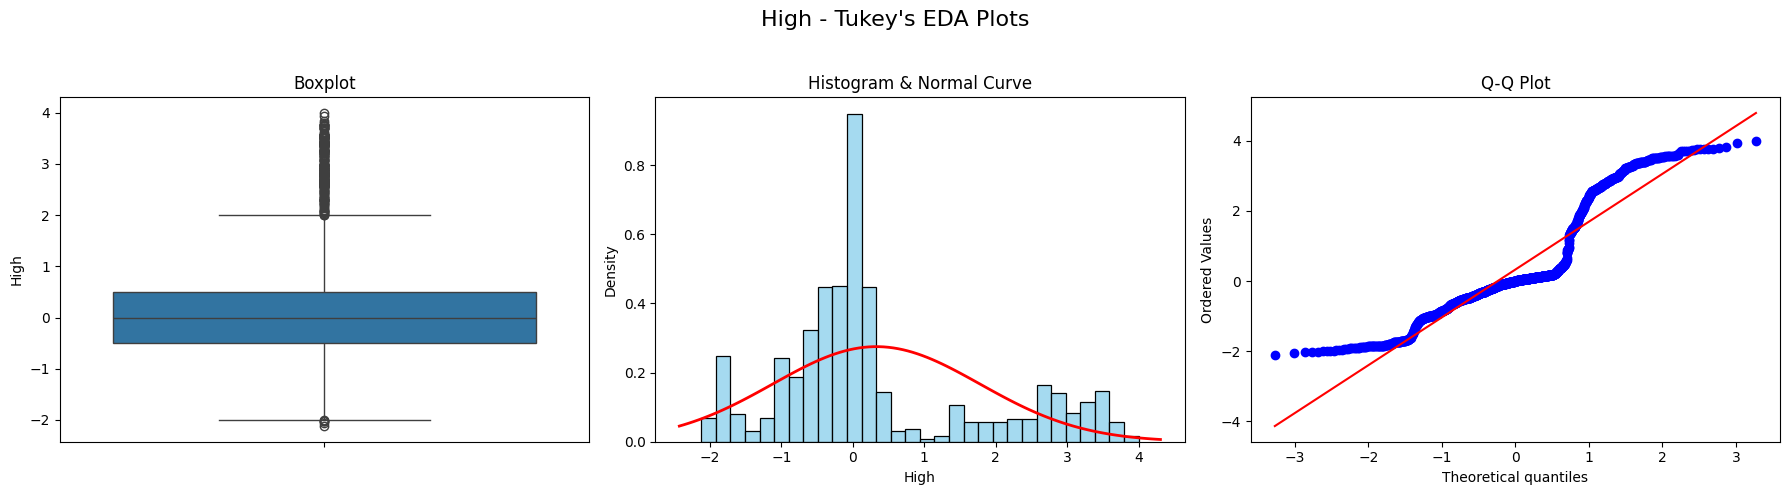

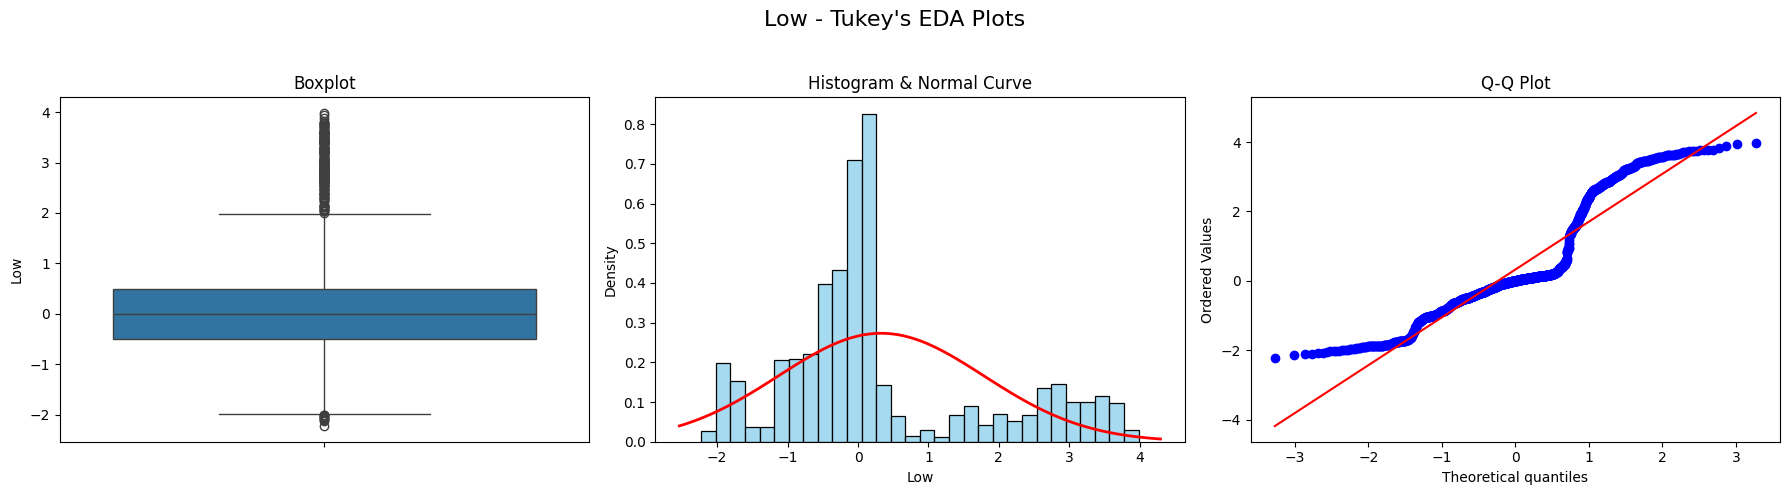

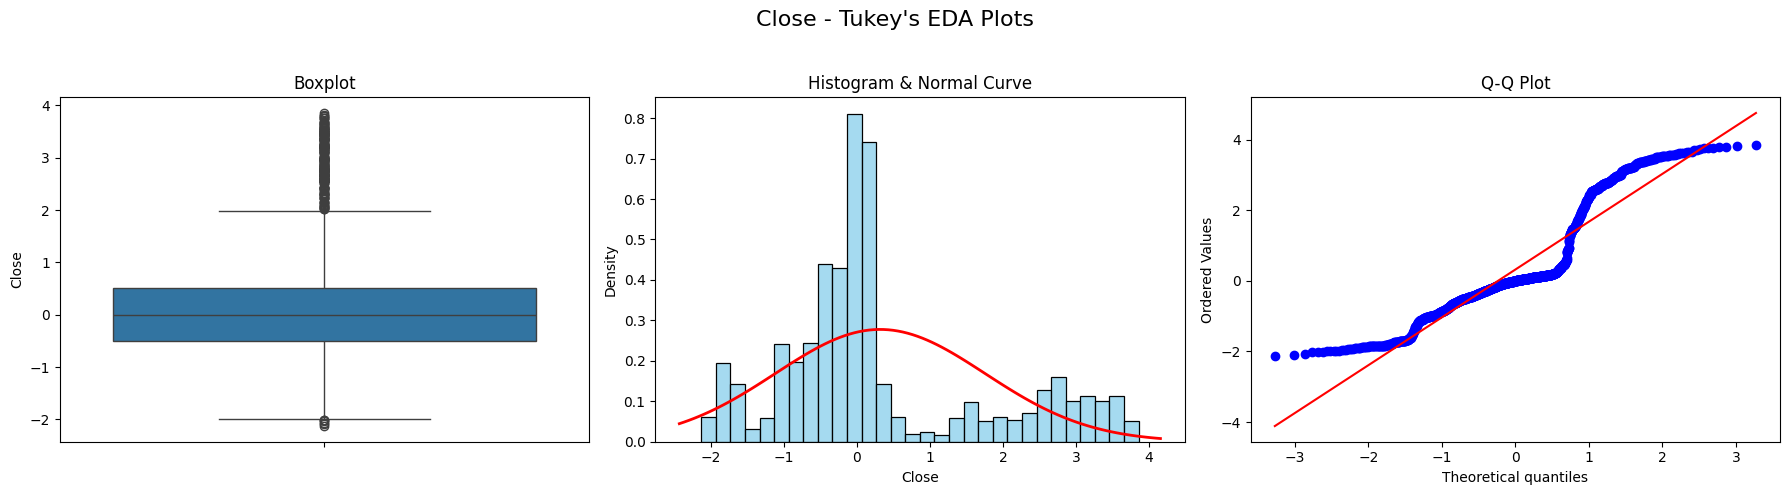

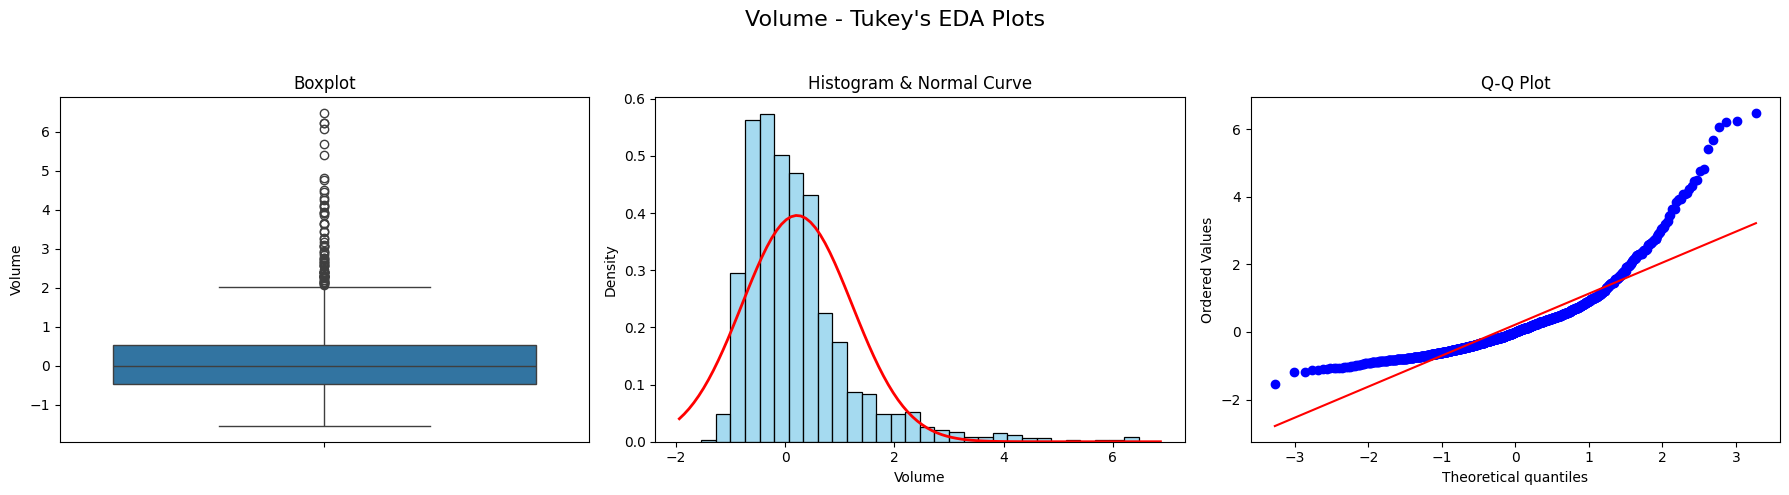

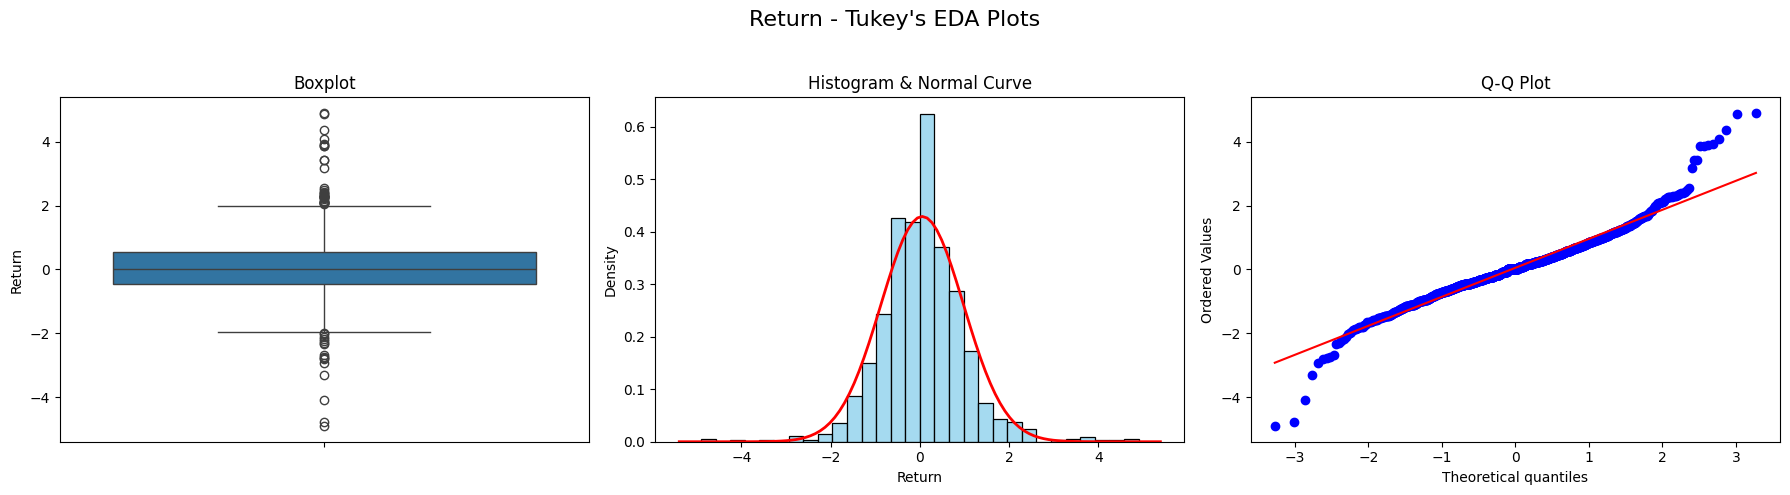

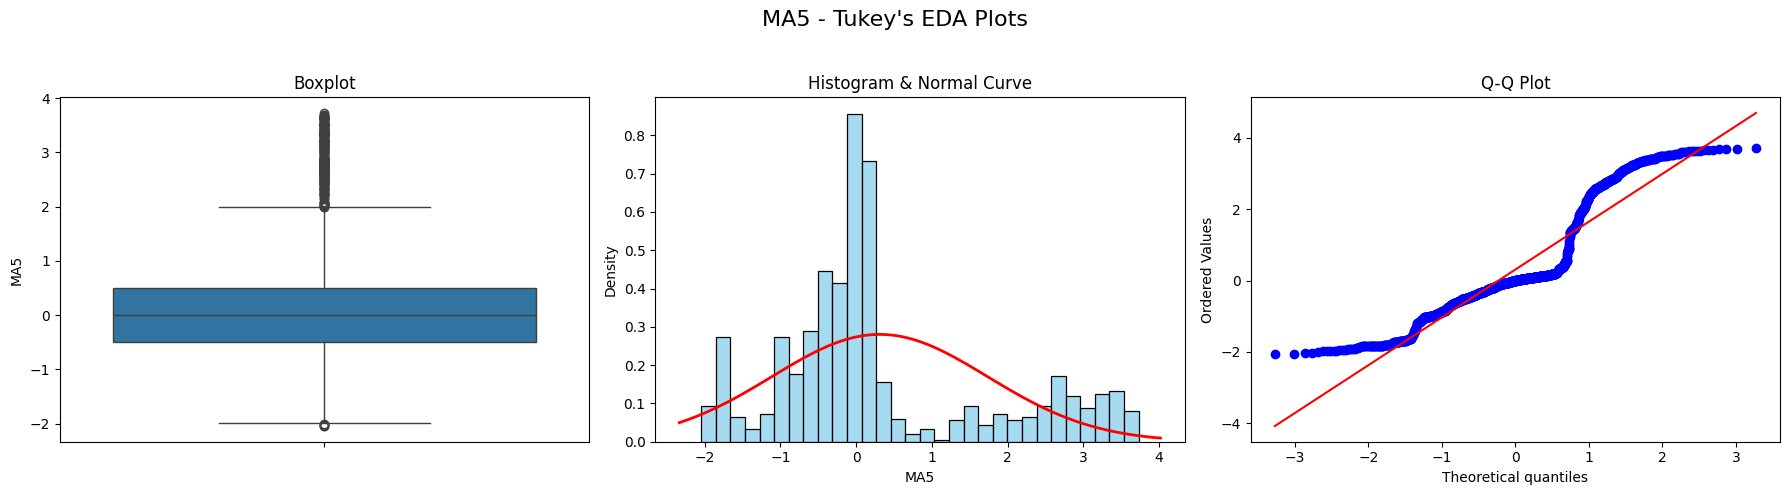

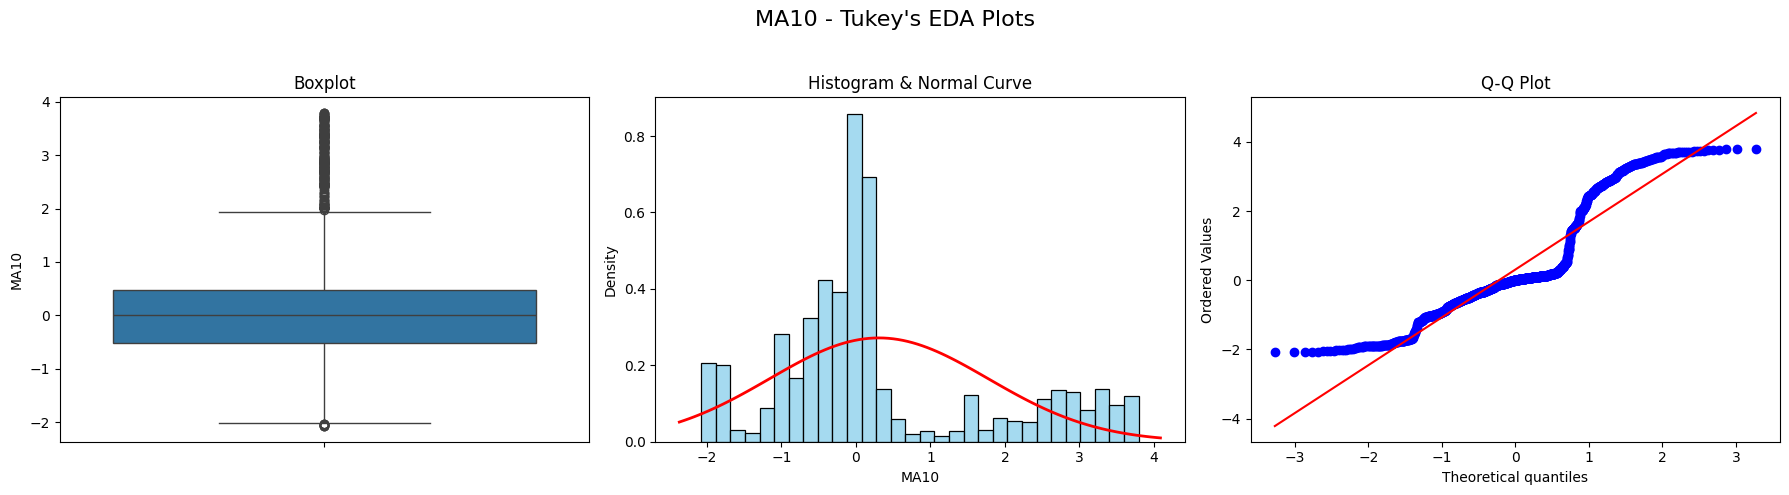

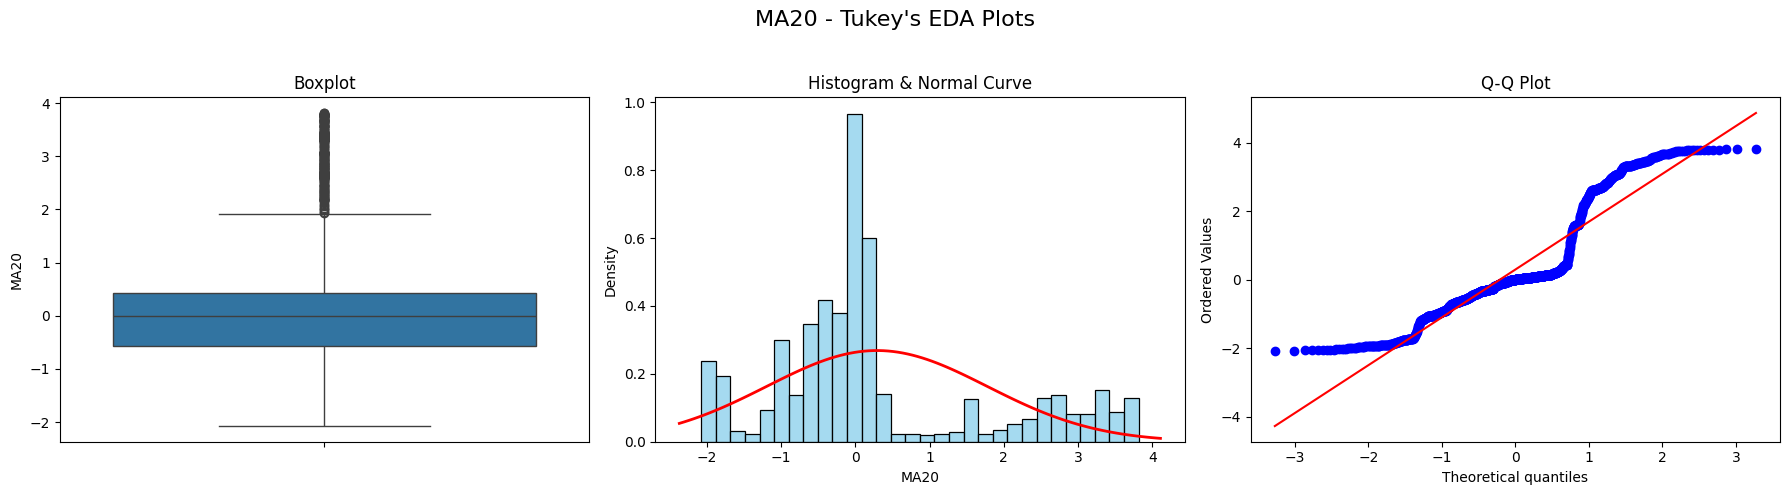

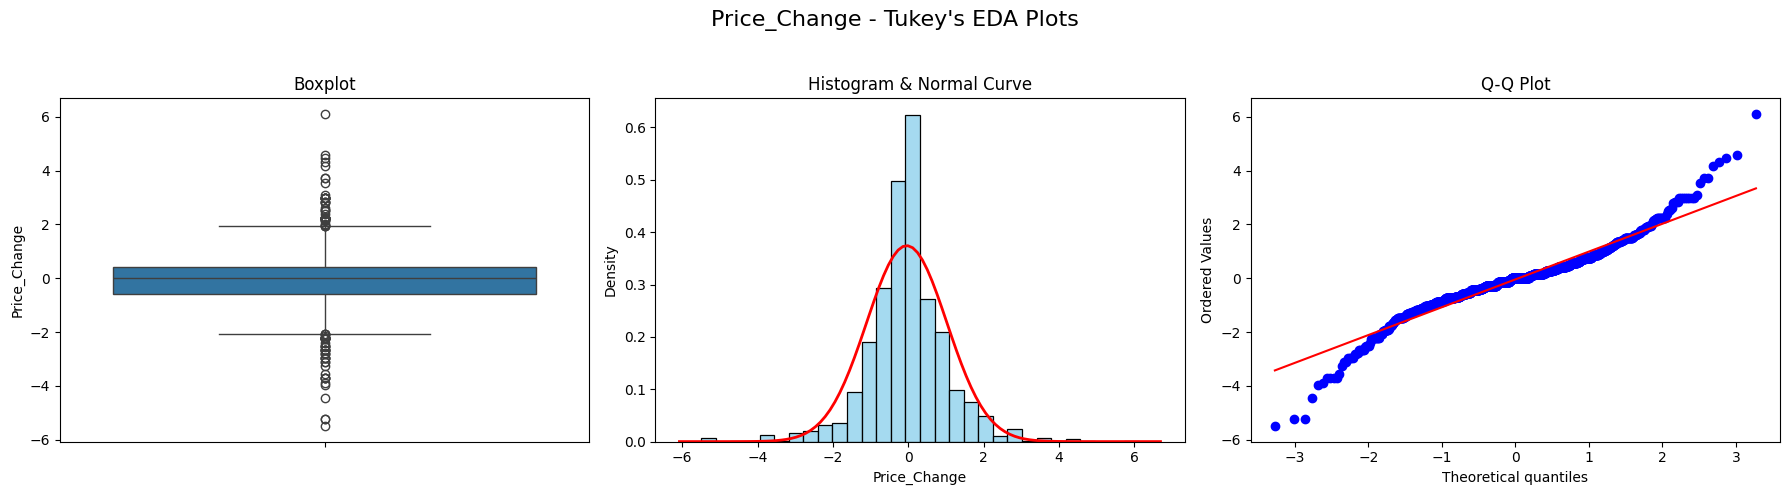

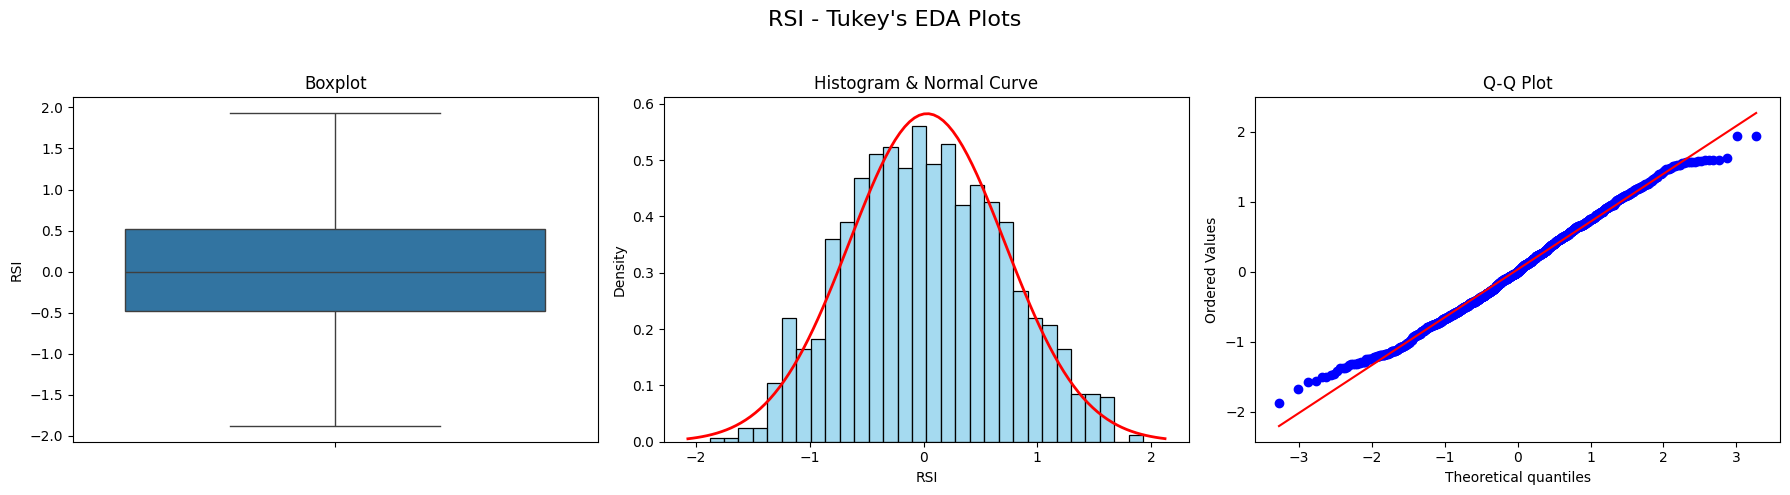

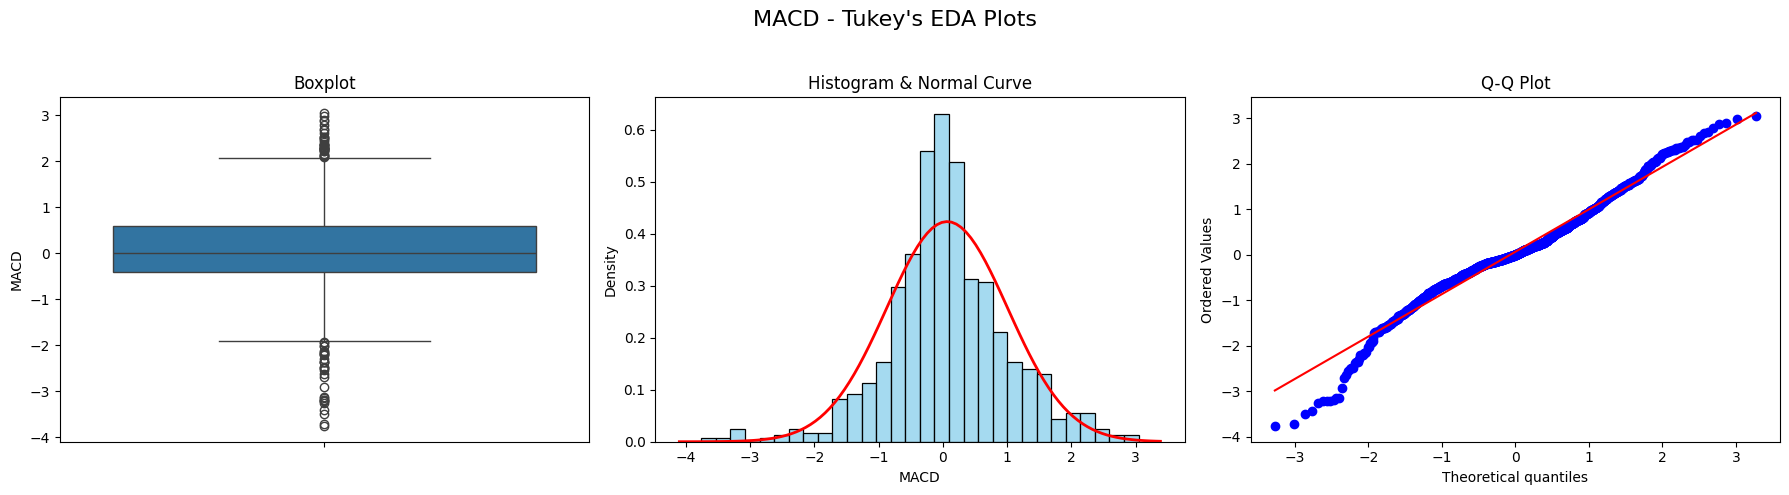

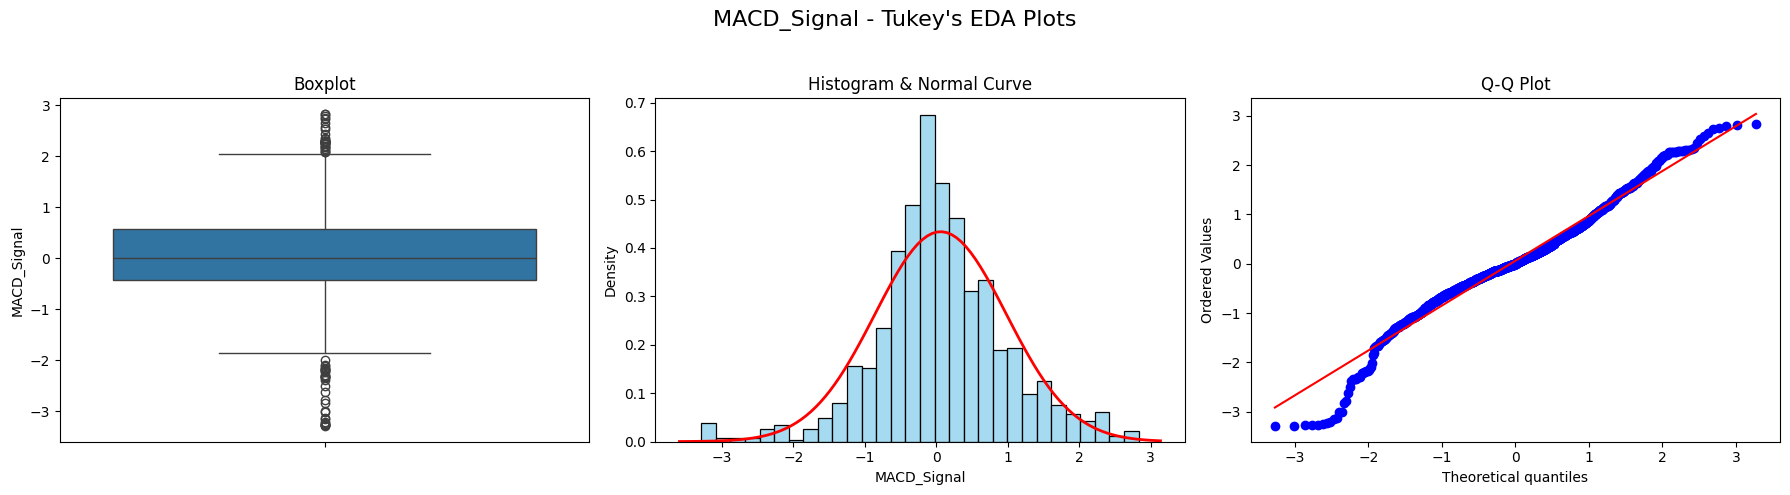

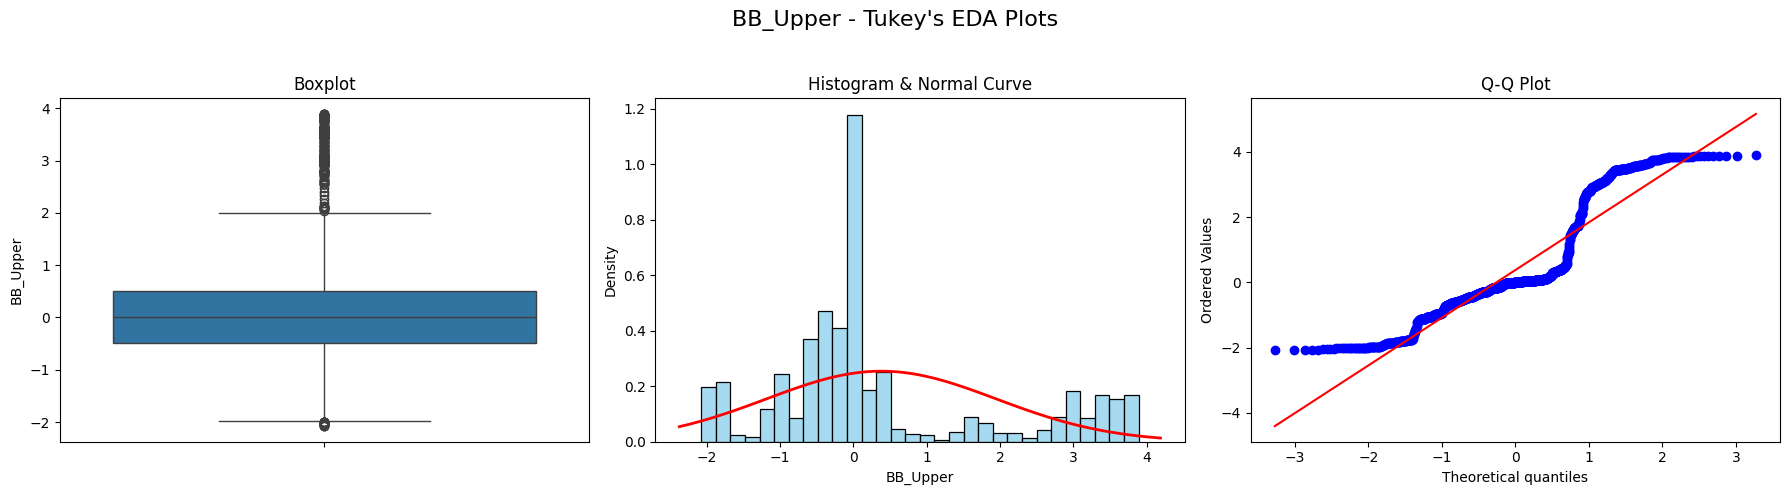

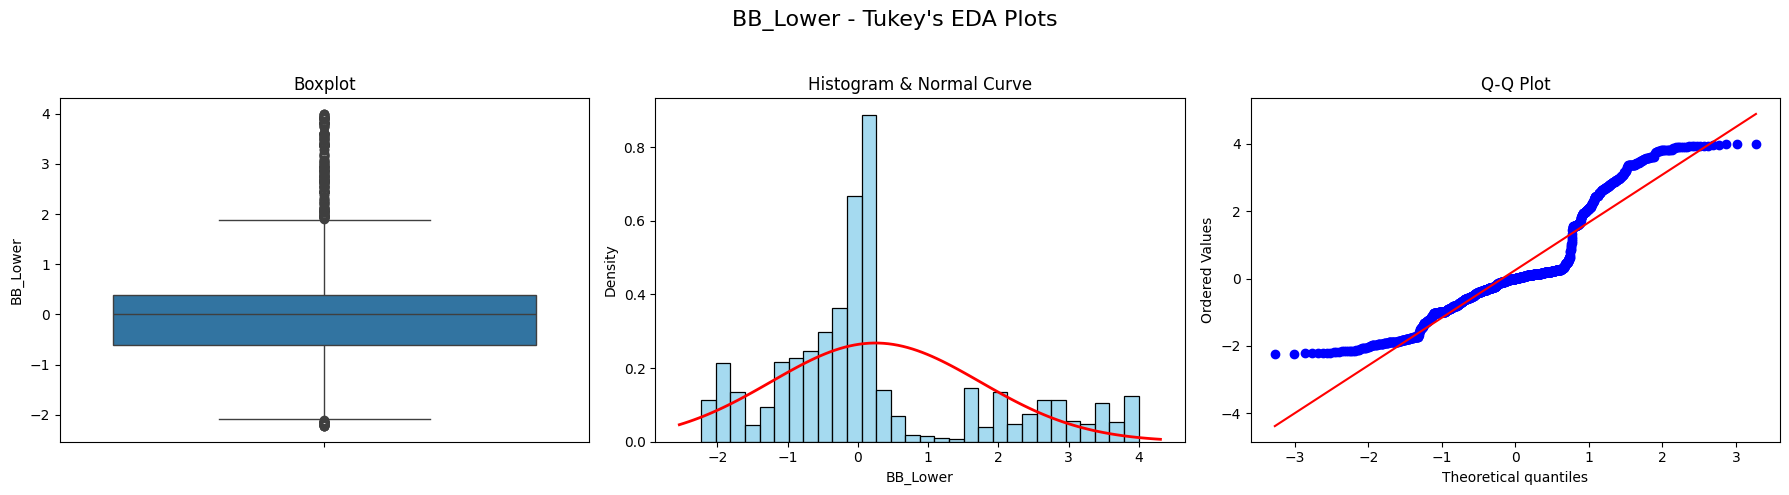

In [13]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

# 需要繪圖的欄位
plot_cols = [col for col in df_robust.columns if col not in ["Date", "Target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{col} - Tukey's EDA Plots", fontsize=16)
    
    # 盒鬚圖 (Boxplot)
    sns.boxplot(y=df_robust[col], ax=axes[0])
    axes[0].set_title("Boxplot")
    
    # 長條圖及常態分佈圖 (Histogram + Normal Curve)
    sns.histplot(df_robust[col], kde=False, stat="density", ax=axes[1], bins=30, color='skyblue')
    # 正態分佈曲線
    mu, std = df_robust[col].mean(), df_robust[col].std()
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1].plot(x, p, 'r', linewidth=2)
    axes[1].set_title("Histogram & Normal Curve")
    
    # Q-Q plot
    stats.probplot(df_robust[col], dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q Plot")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### 特徵選擇
#### 使用Pearson's correlation coefficient 計算

### tsmc2330-2_Robust.csv 熱力圖

In [14]:
#  選擇特徵變數分析
features_analysis = df_robust.drop(columns=["Date"])


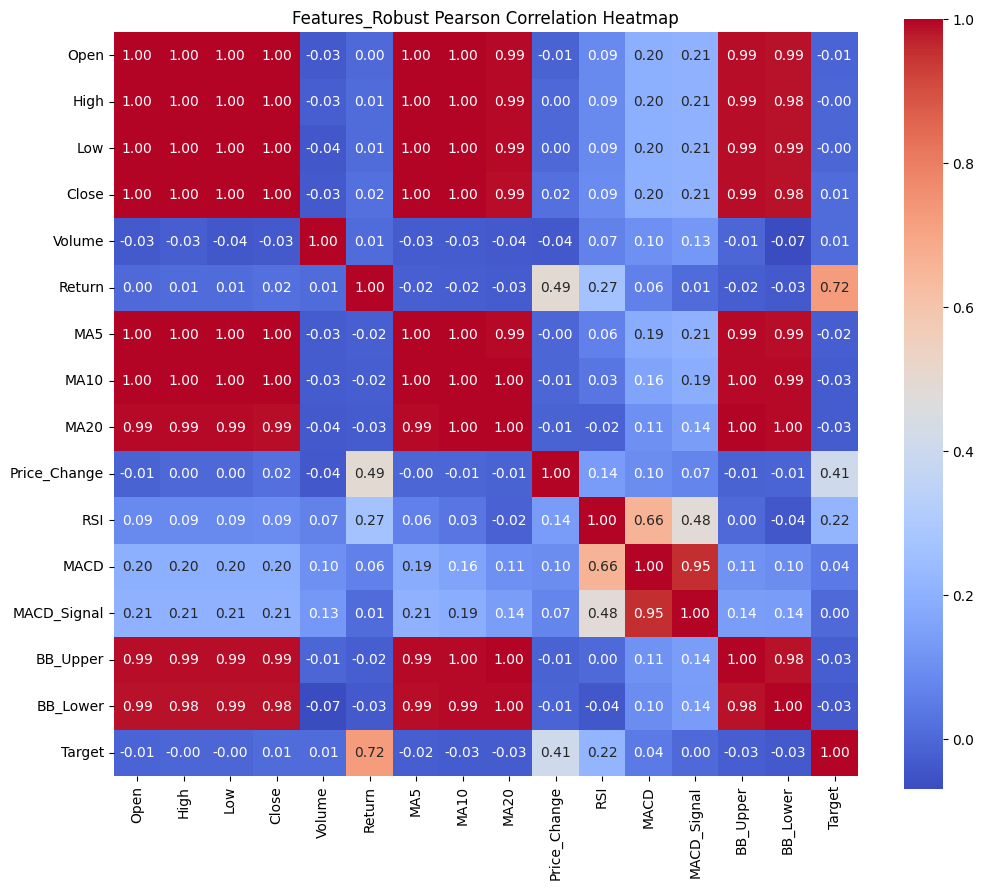

In [15]:
# 計算 Pearson's correlation coefficient
# features_robust =df_robust.drop(columns=["Column1", "Date"]) 上面已經有設定 feature_robust
corr_matrix = features_analysis.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features_Robust Pearson Correlation Heatmap")
plt.show()

### 由熱力圖分析 Pearson's corelation coefficient, 最相關的特徵，其相關係數如下:
- Return: 0.72
- Price change: 0.42
- RSI: 0.23

### 使用 Spearman 相關係數分析特徵變數相關性

In [16]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

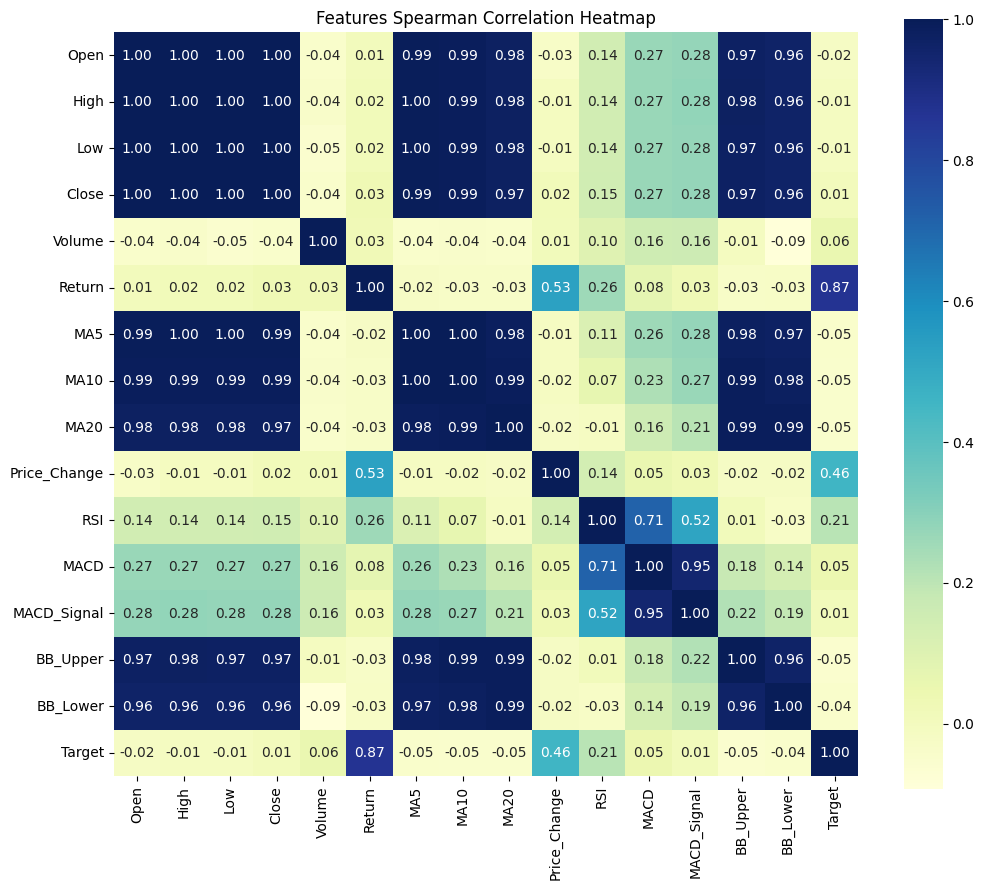

In [17]:
# Spearman 相關係數分析
#features_analysis = df_robust.drop(columns=["Date"])  使用上面的設定
corr_matrix_spearman = features_analysis.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_spearman, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Features Spearman Correlation Heatmap")
plt.show()

相關性高的特徵變數及其相關係數:
- Return: 0.89
- Price_Change: 0.47
- RSI: 0.22

由Pearson 相關係數發現open, high, low, close 區塊、MA5, MA10, MA20 區塊、BB_upper, BB_lower 區塊幾乎都是 1.00 呈現高度共線，表示這些特徵是重複資訊，需重新建構特徵。
其中，Return, Price_change, RSI 是比較高的係數，表示與 Target 相關。

另外的問題是 Return 的計算是使用（今日的收盤價 - 昨日的收盤價）/ 昨日的收盤價
Target 漲跌也是 今日的收盤價 - 昨日的收盤價，用這樣的方式預測結果會100% 準確，
需使用歷史資料來預測明天的漲跌

#### 重新建構特徵

In [18]:
# Load data
df = pd.read_csv('tsmc2330-2_Robust.csv')

# Feature Engineering (Lagged Features)
df['Lag1_Close'] = df['Close'].shift(1)
df['Lag1_Return'] = df['Close'].pct_change().shift(1)
df['Lag1_RSI'] = df['RSI'].shift(1)
df['Lag1_MACD'] = df['MACD'].shift(1)
df['Lag1_MACD_Signal'] = df['MACD_Signal'].shift(1)
df['Volume_Change'] = df['Volume'].pct_change().shift(1)
df['MA5_diff'] = (df['MA5'].shift(1) - df['MA10'].shift(1)) / df['MA10'].shift(1)
df['BB_Pressure'] = df['Close'].shift(1) / df['BB_Upper'].shift(1)
df['Target'] = (df['Close'] > df['Close'].shift(1)).astype(int)

#### 去空值, 設定特徵資料與目標資料

In [19]:
# Drop missing values
features = [
    'Lag1_Close', 'Lag1_Return', 'Lag1_RSI', 'Lag1_MACD', 'Lag1_MACD_Signal',
    'Volume_Change', 'MA5_diff', 'BB_Pressure'
]
df_model = df[features + ['Target']].dropna()
X = df_model[features]
y = df_model['Target']

#### run Pearson's 相關係數分析

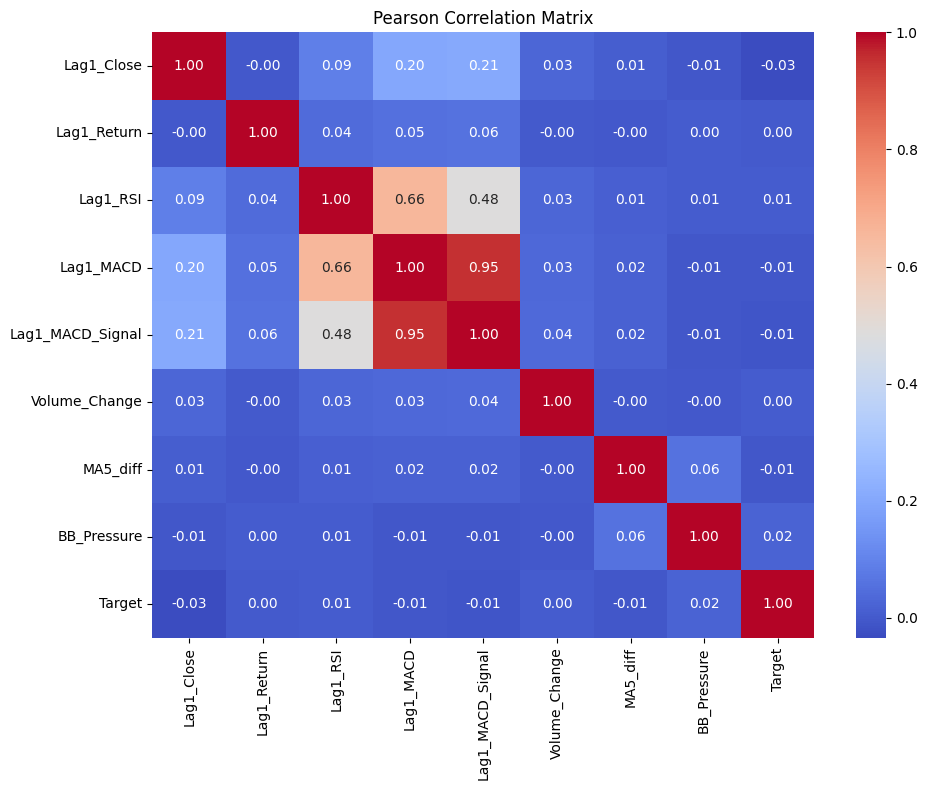

In [20]:
# Pearson Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_model[features + ['Target']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()

從上面可看出 lag1_Close, lag1_RSI, lag1_MACD, lag1_MACD_Signal, MA5_diff, BB_Pressure 相關

#### 特徵標準化

In [22]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 定義模型

In [24]:
import xgboost as xgb
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

#### 依據時間切割資料 （分五段），取代亂數選取測試資料

In [26]:
# Time Series Split
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

#### 模型訓練、評估


==== Logistic Regression ====
CV Accuracy: 0.5144 ± 0.0393


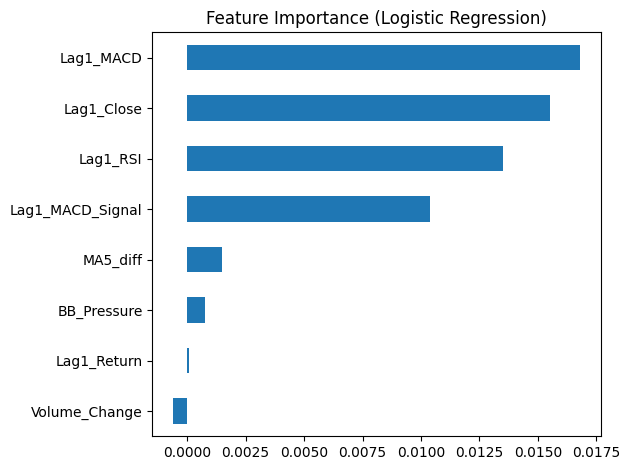


==== Random Forest ====
CV Accuracy: 0.4930 ± 0.0278


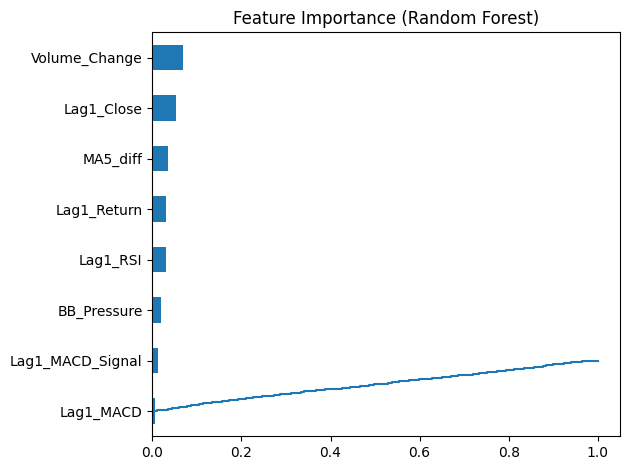


==== XGBoost ====


/Volumes/Data/Github/Python-2025_04_25/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Volumes/Data/Github/Python-2025_04_25/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Volumes/Data/Github/Python-2025_04_25/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Volumes/Data/Github/Python-2025_04_25/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:08:55] WARNING: /Users/runner/work/

CV Accuracy: 0.4735 ± 0.0490


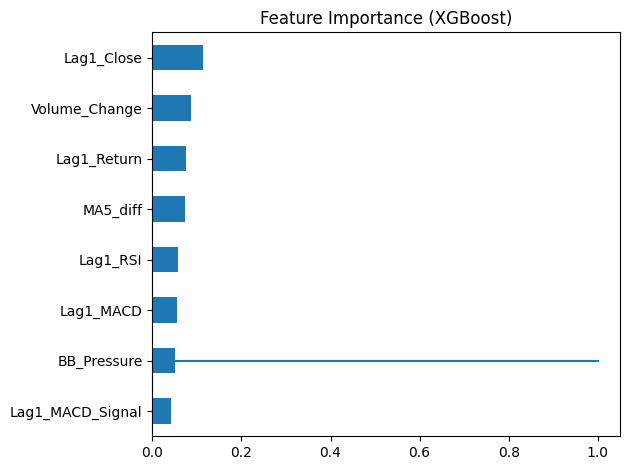

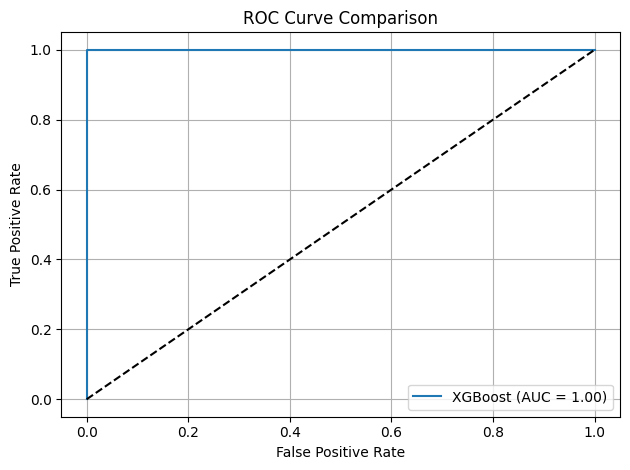

In [29]:
# Train and Evaluate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

for name, model in models.items():
    print(f"\n==== {name} ====")
    model.fit(X_scaled, y)
    scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='accuracy')
    print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

     # Permutation Importance
    result = permutation_importance(model, X_scaled, y, n_repeats=10, random_state=42, scoring='accuracy')
    importance = pd.Series(result.importances_mean, index=features).sort_values()
    importance.plot(kind='barh', title=f'Feature Importance ({name})')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        auc = roc_auc_score(y, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# 📊 分割訓練與測試資料
features = df_robust.drop(columns=["Date", "Target"]) 
X = features
y = df_robust["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)


📘 回歸樹準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       196

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



<Figure size 800x400 with 0 Axes>

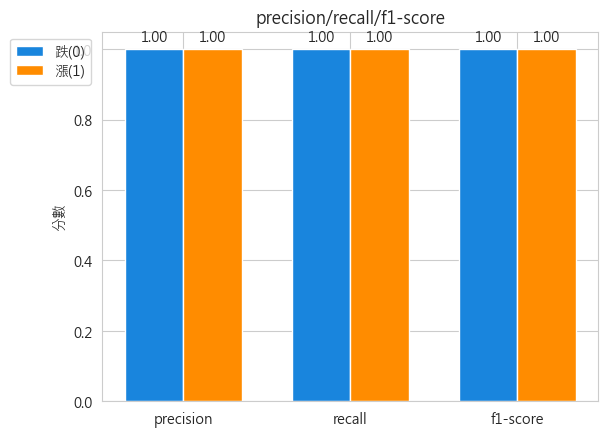

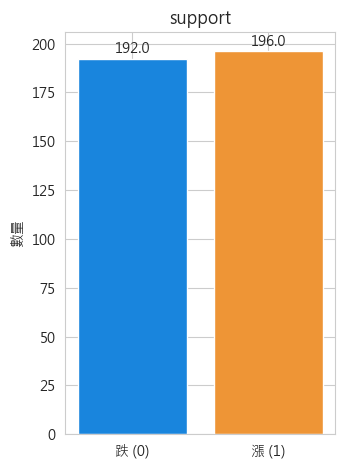

In [ ]:
#  回歸樹模型
tree_model = DecisionTreeClassifier(max_depth=5, random_state=0)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)


print("📘 回歸樹準確率：", accuracy_score(y_test, tree_pred))
print(classification_report(y_test, tree_pred))
report = classification_report(y_test,tree_pred,output_dict= True)
performanceChart(report)

### 計算回歸樹混淆矩陣

回歸樹混淆矩陣：
 [[192   0]
 [  0 196]]


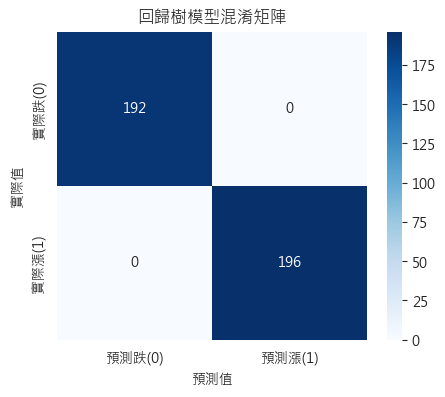

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 計算混淆矩陣
cm = confusion_matrix(y_test, tree_pred)
print("回歸樹混淆矩陣：\n", cm)

# 繪製混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["預測跌(0)", "預測漲(1)"], yticklabels=["實際跌(0)", "實際漲(1)"])
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.title("回歸樹模型混淆矩陣")
plt.show()

📗 隨機森林準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       196

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



<Figure size 800x400 with 0 Axes>

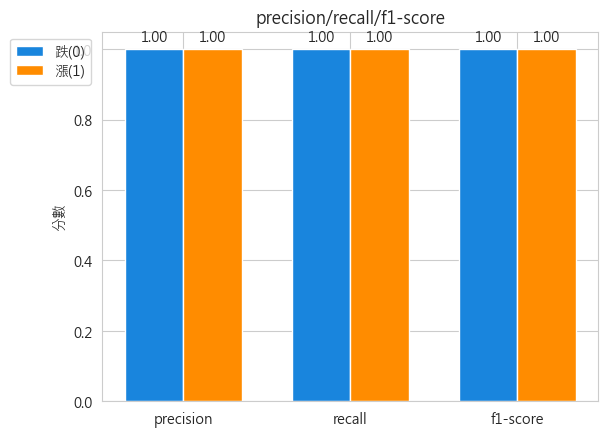

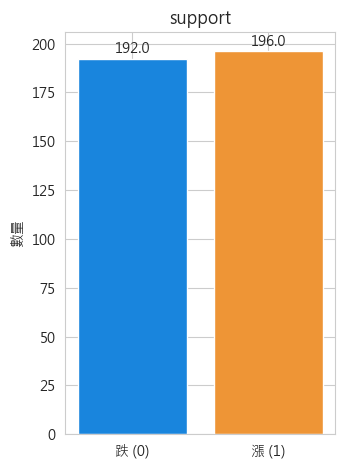

In [39]:
# 🌲 隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("📗 隨機森林準確率：", accuracy_score(y_test, rf_pred))
report = classification_report(y_test, rf_pred, output_dict= True)
print(classification_report(y_test, rf_pred))
performanceChart(report)

#### 隨機森林混淆矩陣圖

隨機森林混淆矩陣：
 [[192   0]
 [  0 196]]


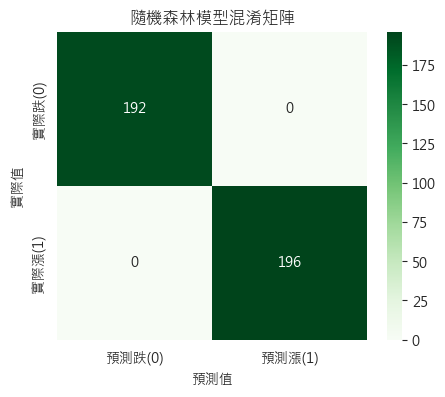

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 計算混淆矩陣
cm_rf = confusion_matrix(y_test, rf_pred)
print("隨機森林混淆矩陣：\n", cm_rf)

# 繪製混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["預測跌(0)", "預測漲(1)"], 
            yticklabels=["實際跌(0)", "實際漲(1)"])
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.title("隨機森林模型混淆矩陣")
plt.show()

📙 邏輯迴歸準確率： 0.979381443298969
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       1.00      0.96      0.98       196

    accuracy                           0.98       388
   macro avg       0.98      0.98      0.98       388
weighted avg       0.98      0.98      0.98       388



<Figure size 800x400 with 0 Axes>

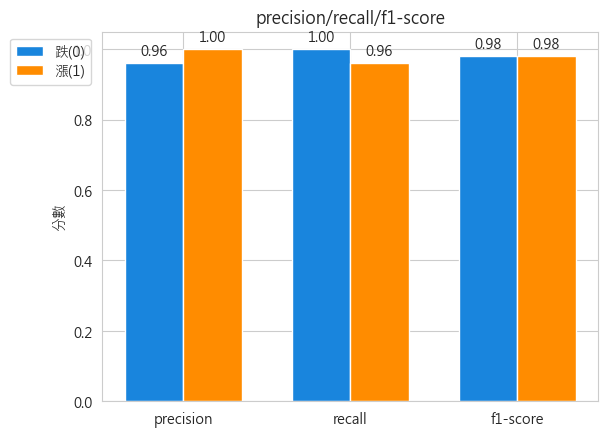

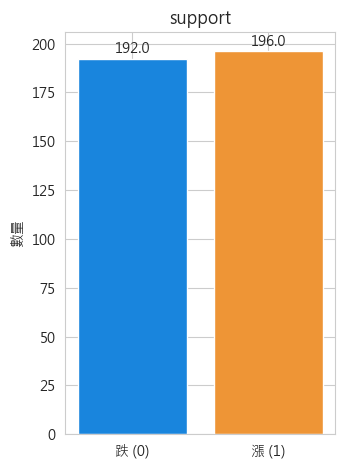

In [40]:
# 📈 邏輯迴歸模型
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#unique_pred = np.unique(lr_pred)
#print("預測中包含的類別:", unique_pred)

print("📙 邏輯迴歸準確率：", accuracy_score(y_test, lr_pred))
report = classification_report(y_test, lr_pred,output_dict= True)
print(classification_report(y_test, lr_pred))
performanceChart(report)




### 邏輯回歸 混淆矩陣圖

邏輯回歸混淆矩陣：
 [[192   0]
 [  8 188]]


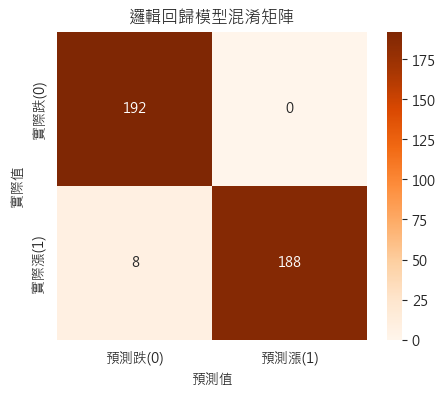

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 計算混淆矩陣
cm_lr = confusion_matrix(y_test, lr_pred)
print("邏輯回歸混淆矩陣：\n", cm_lr)

# 繪製混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=["預測跌(0)", "預測漲(1)"], 
            yticklabels=["實際跌(0)", "實際漲(1)"])
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.title("邏輯回歸模型混淆矩陣")
plt.show()

### 支持向量機(SVM)模型

📒 SVM 準確率： 0.7087628865979382
              precision    recall  f1-score   support

           0       0.87      0.48      0.62       192
           1       0.65      0.93      0.76       196

    accuracy                           0.71       388
   macro avg       0.76      0.71      0.69       388
weighted avg       0.76      0.71      0.69       388



<Figure size 800x400 with 0 Axes>

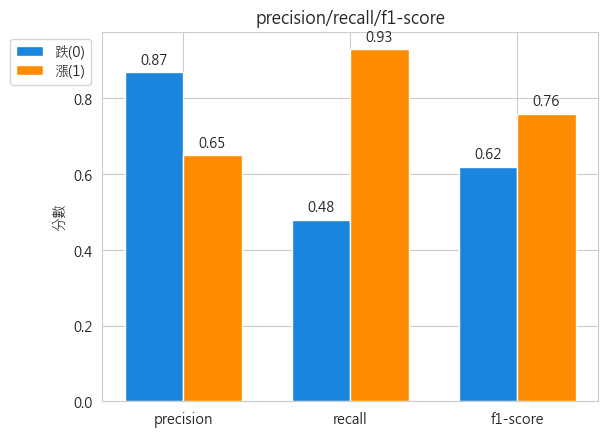

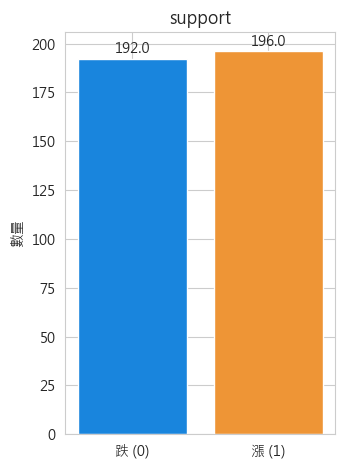

In [41]:
from sklearn.svm import SVC

# 建立並訓練 SVM 模型
svm_model = SVC(kernel='rbf', random_state=0)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("📒 SVM 準確率：", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))
report = classification_report(y_test, svm_pred, output_dict= True)
performanceChart(report)


### 支持向量機 (SVM)混淆矩陣圖

SVM 混淆矩陣：
 [[ 93  99]
 [ 14 182]]


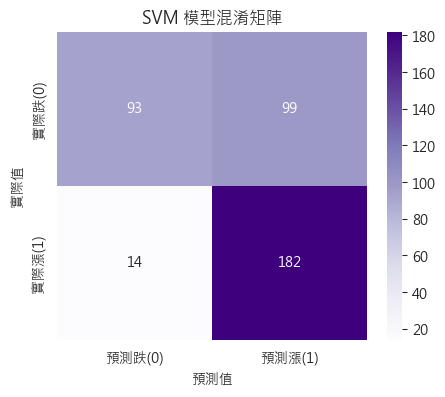

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 計算混淆矩陣
cm_svm = confusion_matrix(y_test, svm_pred)
print("SVM 混淆矩陣：\n", cm_svm)

# 繪製混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples", 
            xticklabels=["預測跌(0)", "預測漲(1)"], 
            yticklabels=["實際跌(0)", "實際漲(1)"])
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.title("SVM 模型混淆矩陣")
plt.show()

### XGBoost 模型

d:\Github\Python-2025_04_25\MLOPS\mlops_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:33:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📕 XGBoost 準確率： 0.9871134020618557
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       192
           1       1.00      0.97      0.99       196

    accuracy                           0.99       388
   macro avg       0.99      0.99      0.99       388
weighted avg       0.99      0.99      0.99       388



<Figure size 800x400 with 0 Axes>

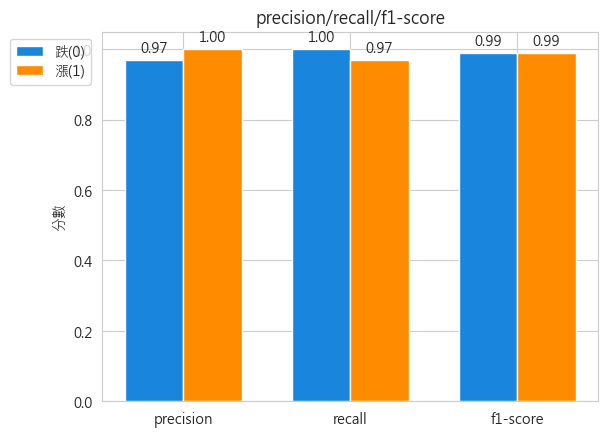

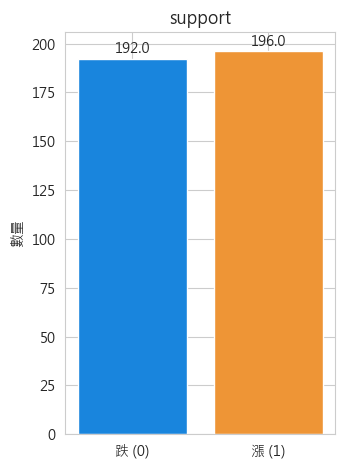

In [47]:
# XGBoost 模型訓練與預測
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("📕 XGBoost 準確率：", accuracy_score(y_test, xgb_pred))
report = classification_report(y_test, xgb_pred, output_dict=True)
print(classification_report(y_test, xgb_pred))
performanceChart(report)

### 請產生XGBoost 混淆矩陣圖

XGBoost 混淆矩陣：
 [[192   0]
 [  5 191]]


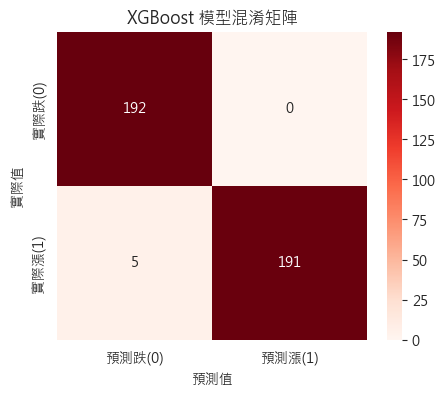

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 計算混淆矩陣
cm_xgb = confusion_matrix(y_test, xgb_pred)
print("XGBoost 混淆矩陣：\n", cm_xgb)

# 繪製混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds", 
            xticklabels=["預測跌(0)", "預測漲(1)"], 
            yticklabels=["實際跌(0)", "實際漲(1)"])
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.title("XGBoost 模型混淆矩陣")
plt.show()

### 下面的重要性分析不用，僅供參考

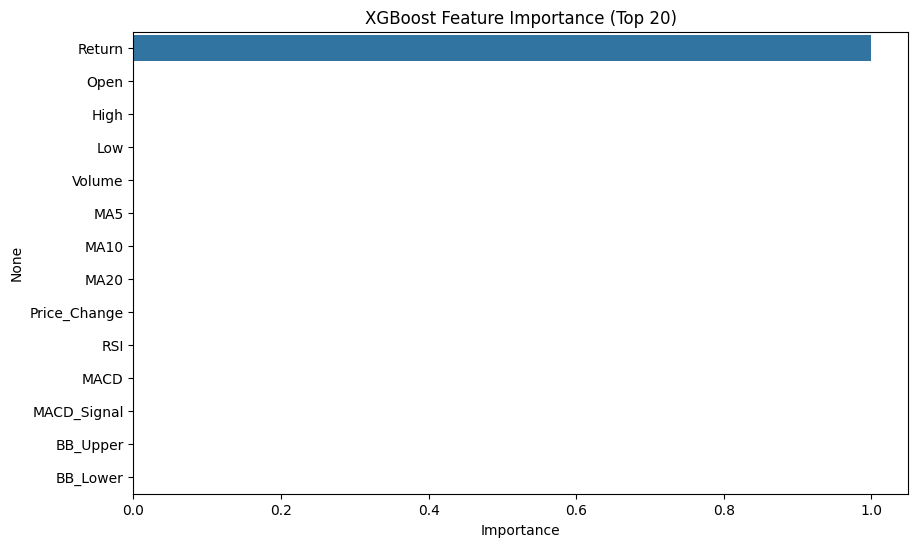

In [49]:
# 模型存檔
import joblib

joblib.dump(rf_model,'model.joblib')
joblib.dump(scaler,'scaler.joblib')

['scaler.joblib']